# Momentum Trading Strategy
We are going to learn how to set up a proper momentum trading strategy, implementing it and backtesting it on historical data.

## Imports

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

# Rundown of Project
We will use the `yfinance` library to get the stock information, and will pull S&P 500 data from as far back as we can get to try to play around with it from Jan 1928 to the present. In terms of what we want to do, we will use the moving average to determine the trend of the stock, and will buy the stock when the stock is above the x-day moving average and close the position when the stock is below the x-day moving average.

In [74]:
class Momentum:
    def __init__(self, data, x, init, tran_cost):
        self.data = pd.DataFrame(data, columns=["Close"])
        self.x = x  # number of days to calculate moving average
        self.init = init  # initial capital
        self.tran_cost = tran_cost  # transaction cost as a fraction

    # function to calculate moving average based on x days
    def SMA(self):
        """
        Calculate the Simple Moving Average (SMA) based on x days
        
        Returns:
        pd.Series: Simple Moving Average (SMA) based on x days and fills NaN values with Close prices of the same day
        """
        return self.data["Close"].rolling(window=self.x).mean().fillna(self.data["Close"])

    # Optimized trade function using vectorized operations
    def trade(self):
        """
        Simulate trading based on the moving average strategy

        Returns:
        pd.DataFrame: DataFrame containing new columns for:
        - trading signals
        - positions
        - shares
        - cash
        - transaction costs
        - returns
        - cumulative returns
        """
        data = self.data.copy()
        data.index = pd.to_datetime(data.index)
        data["SMA"] = self.SMA()

        # Initialize portfolio, shares, cash, and transaction cost
        data["Position"] = 0
        data["Shares"] = 0
        data["Tran_Cost"] = 0
        data["Cash"] = 0

        data["Cash"].iloc[0] = self.init
        data["Position"].iloc[0] = self.init

        # check if price is above or below moving average using pandas
        data["Signal"] = np.where(data["Close"] > data["SMA"], 1, 0)
        data["Signal"] = data["Signal"].diff().fillna(0)
        data["Buy"] = np.where(data["Signal"] == 1, data["Close"], np.nan)
        data["Sell"] = np.where(data["Signal"] == -1, data["Close"], np.nan)

        # Calculate shares and cash
        for i in range(1, len(data)):
            if data["Signal"].iloc[i] == 1:
                # buy as many shares whole (non decimal) as funds allow
                data["Shares"].iloc[i] = data["Cash"].iloc[i - 1] // (data["Close"].iloc[i] * (1 + self.tran_cost))
                data["Tran_Cost"].iloc[i] = data["Shares"].iloc[i] * data["Close"].iloc[i] * self.tran_cost
                data["Cash"].iloc[i] = data["Cash"].iloc[i - 1] - data["Shares"].iloc[i] * data["Close"].iloc[i] - data["Tran_Cost"].iloc[i]
                data["Position"].iloc[i] = data["Shares"].iloc[i] * data["Close"].iloc[i] + data["Cash"].iloc[i]
            elif data["Signal"].iloc[i] == -1:
                data["Cash"].iloc[i] = data["Cash"].iloc[i - 1] + data["Shares"].iloc[i - 1] * data["Close"].iloc[i] * (1 - self.tran_cost)
                data["Tran_Cost"].iloc[i] = data["Shares"].iloc[i - 1] * data["Close"].iloc[i] * self.tran_cost
                data["Shares"].iloc[i] = 0
                data["Position"].iloc[i] = data["Cash"].iloc[i]
            else:
                data["Cash"].iloc[i] = data["Cash"].iloc[i - 1]
                data["Shares"].iloc[i] = data["Shares"].iloc[i - 1]
                data["Position"].iloc[i] = data["Shares"].iloc[i] * data["Close"].iloc[i] + data["Cash"].iloc[i]

        # Calculate returns and cumulative returns
        data["Returns"] = data["Position"].pct_change().fillna(0)
        data["Cum_Returns"] = (1 + data["Returns"]).cumprod()

        # index returns for comparison
        data["Index_Returns"] = data["Close"].pct_change().fillna(0)
        data["Index_Cum_Returns"] = (1 + data["Index_Returns"]).cumprod()

        self.data = data

        return data
    
    def performance(self):
        """
        Calculate performance metrics for the trading strategy

        Args:
        data (pd.DataFrame): DataFrame containing trading strategy data

        Returns:
        pd.DataFrame: DataFrame containing performance metrics for both the trading strategy and the index
        """
        # Calculate annualized returns
        returns = self.data["Returns"]
        index_returns = self.data["Index_Returns"]

        annualized_returns = (1 + returns.mean()) ** 252 - 1
        annualized_index_returns = (1 + index_returns.mean()) ** 252 - 1

        # Calculate annualized volatility
        annualized_volatility = returns.std() * np.sqrt(252)
        annualized_index_volatility = index_returns.std() * np.sqrt(252)

        # Calculate Sharpe ratio
        sharpe_ratio = annualized_returns / annualized_volatility
        index_sharpe_ratio = annualized_index_returns / annualized_index_volatility

        # Create a DataFrame to display the metrics
        metrics = pd.DataFrame({
            "Trading Strategy": [annualized_returns, annualized_volatility, sharpe_ratio],
            "Index": [annualized_index_returns, annualized_index_volatility, index_sharpe_ratio]
        }, index=["Annualized Returns", "Annualized Volatility", "Sharpe Ratio"])

        return metrics
    
    def SMA_signals_plot(self):
        """
        Plot the trading signals and moving average strategy

        Args:
        data (pd.DataFrame): DataFrame containing trading strategy data
        """
        # Create a figure and axis
        plt.figure(figsize=(15, 7))

        # Plot Close and SMA
        plt.plot(self.data.index, self.data["Close"], label='Close', color='blue')
        plt.plot(self.data.index, self.data["SMA"], label='SMA', color='orange')

        # Add buy and sell signals
        plt.scatter(self.data.index, self.data["Buy"], marker='^', color='green', label='Buy', alpha=1)
        plt.scatter(self.data.index, self.data["Sell"], marker='v', color='red', label='Sell', alpha=1)

        # Add title and labels
        plt.title("Moving Average Strategy")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid()

        # Show the plot
        plt.show()

    def performance_plot(self):
        """
        Plot the cumulative returns of the trading strategy and the index

        Args:
        data (pd.DataFrame): DataFrame containing trading strategy data
        """
        # Create a figure and axis
        plt.figure(figsize=(20, 7))

        # Plot cumulative returns
        plt.plot(self.data.index, self.data["Cum_Returns"], label='Trading Strategy', color='blue')
        plt.plot(self.data.index, self.data["Index_Cum_Returns"], label='Index', color='orange')

        # Add title and labels
        plt.title("Cumulative Returns")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid()

        # Show the plot
        plt.show()


In [3]:
# pull SPX data from Jan 1928
spx = yf.Ticker("^GSPC")
spx_close = spx.history(start="1928-01-01")["Close"]

In [75]:
# Initialize the Momentum class
trade = Momentum(spx_close, 200, 1000000, 0.001)
trade.trade()

,Close,SMA,Position,Shares,Tran_Cost,Cash,Signal,Buy,Sell,Returns,Cum_Returns,Index_Returns,Index_Cum_Returns
Date,,,,,,,,,,,,,
1928-01-03 00:00:00-05:00,17.760000,17.760000,1.000000e+06,0,0.0,1000000.000000,0.0,NaN,NaN,0.000000,1.000000,0.000000,1.000000
1928-01-04 00:00:00-05:00,17.719999,17.719999,1.000000e+06,0,0.0,1000000.000000,0.0,NaN,NaN,0.000000,1.000000,-0.002252,0.997748
1928-01-05 00:00:00-05:00,17.549999,17.549999,1.000000e+06,0,0.0,1000000.000000,0.0,NaN,NaN,0.000000,1.000000,-0.009594,0.988176
1928-01-06 00:00:00-05:00,17.660000,17.660000,1.000000e+06,0,0.0,1000000.000000,0.0,NaN,NaN,0.000000,1.000000,0.006268,0.994369
1928-01-09 00:00:00-05:00,17.500000,17.500000,1.000000e+06,0,0.0,1000000.000000,0.0,NaN,NaN,0.000000,1.000000,-0.009060,0.985360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-18 00:00:00-04:00,5618.259766,5188.647805,2.806161e+08,49947,0.0,853.953764,0.0,NaN,NaN,-0.002896,280.616074,-0.002896,316.343451
2024-09-19 00:00:00-04:00,5713.640137,5194.242856,2.853800e+08,49947,0.0,853.953764,0.0,NaN,NaN,0.016977,285.380038,0.016977,321.713968
2024-09-20 00:00:00-04:00,5702.549805,5199.906707,2.848261e+08,49947,0.0,853.953764,0.0,NaN,NaN,-0.001941,284.826109,-0.001941,321.089512


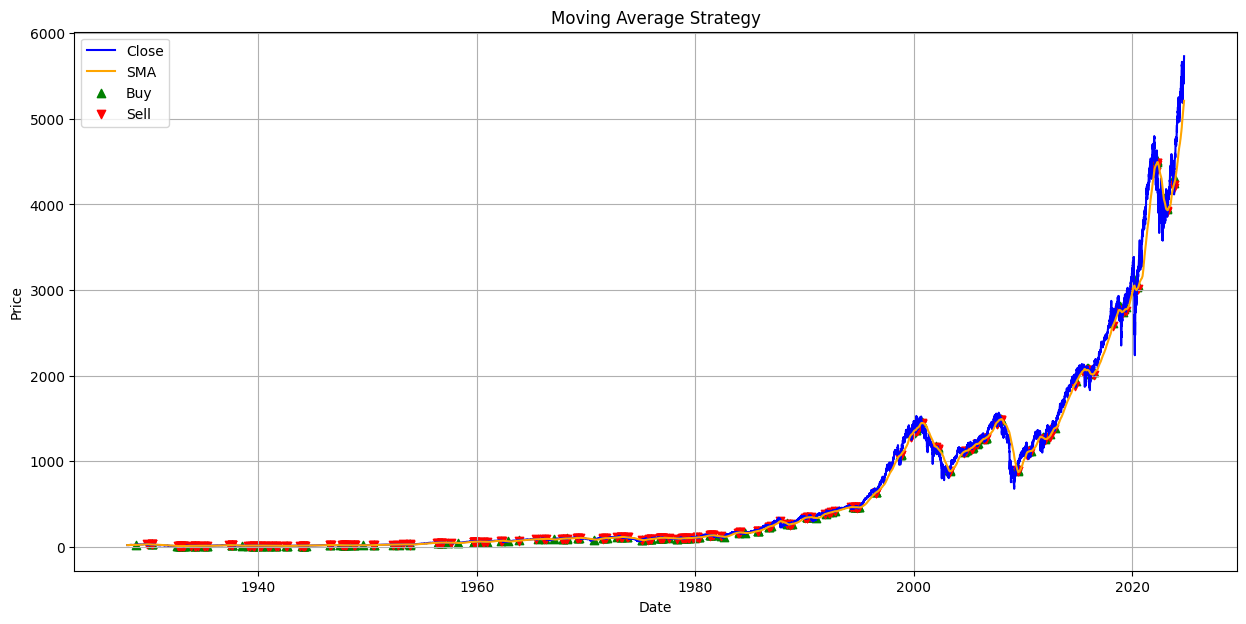

In [76]:
# show moving average signals
trade.SMA_signals_plot()

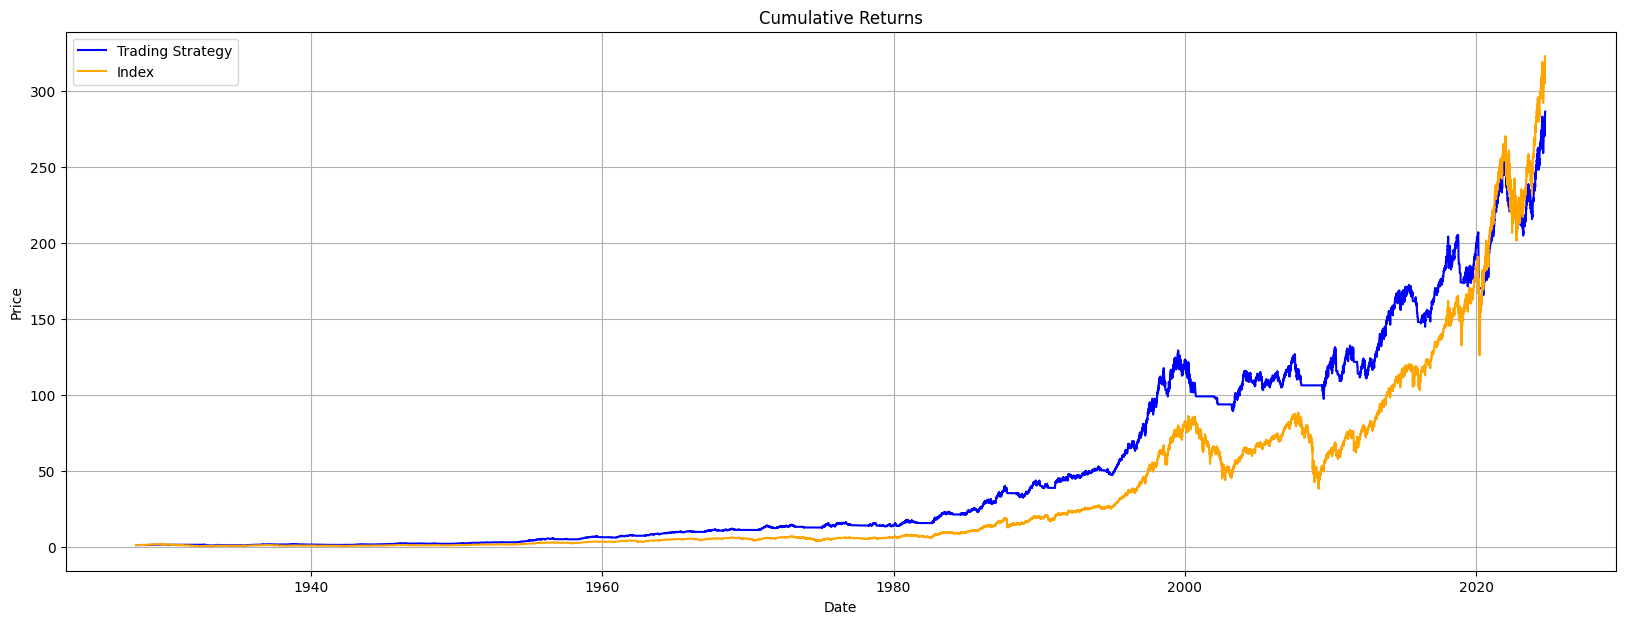

,Trading Strategy,Index
Annualized Returns,0.068323,0.081032
Annualized Volatility,0.121679,0.189574
Sharpe Ratio,0.561504,0.427443


In [77]:
# plot performance
trade.performance_plot()

# show performance metrics
trade.performance()

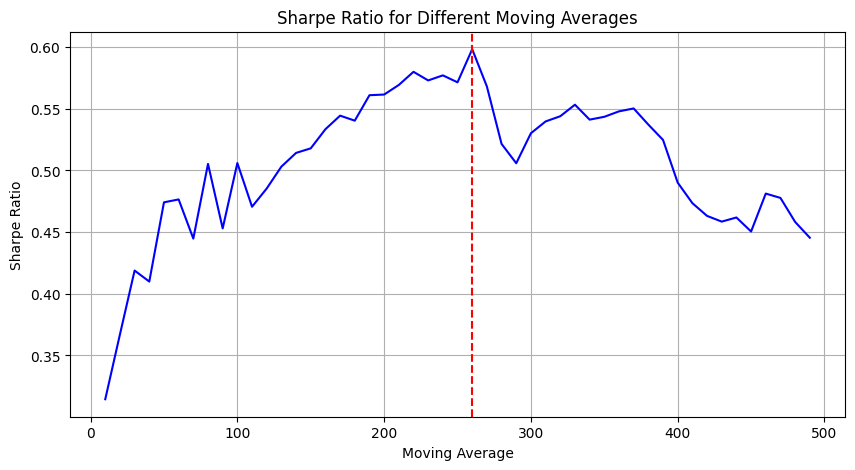

    Moving Average  Sharpe Ratio
25             260      0.598244


In [78]:
# using our same class, we can test different moving averages and find the one with the best sharpe
sharpe_data = []

# Initialize the Momentum class
for i in range(10, 500, 10):
    trade = Momentum(spx_close, i, 1000000, 0.001)
    trade.trade()
    metrics = trade.performance()
    sharpe_data.append([i, metrics.loc["Sharpe Ratio", "Trading Strategy"]])

sharpe_data = pd.DataFrame(sharpe_data, columns=["Moving Average", "Sharpe Ratio"])

# Plot the Sharpe ratio for different moving averages
plt.figure(figsize=(10, 5))
plt.plot(sharpe_data["Moving Average"], sharpe_data["Sharpe Ratio"], color='blue')
#max sharpe and SMA ratio indicator
plt.axvline(x=sharpe_data["Moving Average"][sharpe_data["Sharpe Ratio"].idxmax()], color='red', linestyle='--')
plt.title("Sharpe Ratio for Different Moving Averages")
plt.xlabel("Moving Average")
plt.ylabel("Sharpe Ratio")
plt.grid()
plt.show()
print(sharpe_data[sharpe_data["Sharpe Ratio"] == sharpe_data["Sharpe Ratio"].max()])
